In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

L = 10.0
T_MAX = 1.0

ALPHA_MIN = 0.1
ALPHA_MAX = 1.5


N_pde = 10000  
N_ic = 5000  
N_bc = 5000 

# Устройство для вычислений
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")



def generate_points(N_pde, N_ic, N_bc, L, T_MAX, ALPHA_MIN, ALPHA_MAX, device):

    pde_x = torch.rand(N_pde, 1, device=device) * L
    pde_t = torch.rand(N_pde, 1, device=device) * T_MAX
    pde_alpha = torch.rand(N_pde, 1, device=device) * (ALPHA_MAX - ALPHA_MIN) + ALPHA_MIN
    pde_points = torch.cat([pde_x, pde_t, pde_alpha], dim=1)


    ic_x = torch.linspace(0, L, N_ic, device=device).view(-1, 1)
    ic_t = torch.zeros(N_ic, 1, device=device)
    ic_alpha = torch.rand(N_ic, 1, device=device) * (ALPHA_MAX - ALPHA_MIN) + ALPHA_MIN
    ic_points = torch.cat([ic_x, ic_t, ic_alpha], dim=1)


    bc_t = torch.rand(N_bc // 2, 1, device=device) * T_MAX
    bc_alpha_left = torch.rand(N_bc // 2, 1, device=device) * (ALPHA_MAX - ALPHA_MIN) + ALPHA_MIN
    bc_alpha_right = torch.rand(N_bc // 2, 1, device=device) * (ALPHA_MAX - ALPHA_MIN) + ALPHA_MIN

    bc_x_left = torch.zeros(N_bc // 2, 1, device=device)
    bc_points_left = torch.cat([bc_x_left, bc_t, bc_alpha_left], dim=1)

    bc_x_right = torch.full((N_bc // 2, 1), L, device=device)
    bc_points_right = torch.cat([bc_x_right, bc_t, bc_alpha_right], dim=1)

    bc_points = torch.cat([bc_points_left, bc_points_right], dim=0)

    return pde_points, ic_points, bc_points

pde_points, ic_points, bc_points = generate_points(N_pde, N_ic, N_bc, L, T_MAX, ALPHA_MIN, ALPHA_MAX, device)

Используемое устройство: cpu


In [2]:
def analytical_solution_heat(x, t, alpha, L):
    ##Аналитическое решения уравнения теплопроводности
    return torch.sin(torch.pi * x / L) * torch.exp(-alpha * (torch.pi / L)**2 * t)

In [3]:
class PINN(nn.Module):
    def __init__(self, n_hidden=100, n_layers=5):
        super(PINN, self).__init__()
        layers = []

        layers.append(nn.Linear(3, n_hidden))
        layers.append(nn.SiLU())

        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(nn.SiLU())

        layers.append(nn.Linear(n_hidden, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x_t_alpha):
        return self.net(x_t_alpha)



In [4]:
##График ошибки по физике - среднеквадратичная ошибка
def pde_loss_heat(model, pde_points):

    x = pde_points[:, [0]].detach().clone().requires_grad_(True)
    t = pde_points[:, [1]].detach().clone().requires_grad_(True)
    alpha = pde_points[:, [2]]


    xta = torch.cat([x, t, alpha], dim=1)
    u = model(xta)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    residual = u_t - alpha * u_xx
    return torch.mean(residual**2)


In [5]:
def f_initial_condition_heat(x, L):
    return torch.sin(torch.pi * x / L)

#ошибка начального условия - среднеквадратичная
def initial_condition_loss(model, ic_points, L):
    ic_x = ic_points[:, 0:1]

    u_pred_ic = model(ic_points)

    u_true_ic = f_initial_condition_heat(ic_x, L)
    loss = torch.mean((u_pred_ic - u_true_ic)**2)
    return loss

In [6]:
#ошибка граничных условий - среднеквадратичная
def boundary_condition_loss(model, bc_points):


    u_pred_bc = model(bc_points)

    u_true_bc = torch.zeros_like(u_pred_bc)
    loss = torch.mean((u_pred_bc - u_true_bc)**2)
    return loss


In [ ]:
#Сейчас используется sgd
pinn_model = PINN(n_hidden=60, n_layers=6).to(device)
optimizer = torch.optim.SGD(pinn_model.parameters(), lr=1e-9, momentum=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=500)

num_epochs = 800
print_every = 100

epoch_history = []
total_loss_history = []
pde_loss_history = []
ic_loss_history = []
bc_loss_history = []

w_pde = 1.0
w_ic = 50.0
w_bc = 10.0

start_time = time.time()
pinn_model.train()

for epoch in range(num_epochs):

    optimizer.zero_grad()


    l_pde = pde_loss_heat(pinn_model, pde_points)
    l_ic = initial_condition_loss(pinn_model, ic_points, L)
    l_bc = boundary_condition_loss(pinn_model, bc_points)

    total_loss = w_pde * l_pde + w_ic * l_ic + w_bc * l_bc

    total_loss.backward()

    optimizer.step()
    scheduler.step(total_loss)

    if (epoch + 1) % 10 == 0:
        epoch_history.append(epoch + 1)
        total_loss_history.append(total_loss.item())
        pde_loss_history.append(l_pde.item())
        ic_loss_history.append(l_ic.item())
        bc_loss_history.append(l_bc.item())

    if (epoch + 1) % print_every == 0:
        print(f"Эпоха {epoch+1}/{num_epochs} | "
              f"Total Loss: {total_loss.item():.6f} | "
              f"PDE: {l_pde.item():.6f} | "
              f"IC: {l_ic.item():.6f} | "
              f"BC: {l_bc.item():.6f}")

end_time = time.time()
print(f"--- Обучение завершено за {end_time - start_time:.2f} секунд. ---")

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  current = float(metrics)


Эпоха 100/400 | Total Loss: 1.044473 | PDE: 0.000000 | IC: 0.127517 | BC: 0.203442
Эпоха 200/400 | Total Loss: 0.266873 | PDE: 0.004648 | IC: 0.035626 | BC: 0.021131
Эпоха 300/400 | Total Loss: 0.048564 | PDE: 0.002502 | IC: 0.003072 | BC: 0.004094
Эпоха 400/400 | Total Loss: 0.034649 | PDE: 0.001858 | IC: 0.002082 | BC: 0.002830
--- Обучение завершено за 205.76 секунд. ---


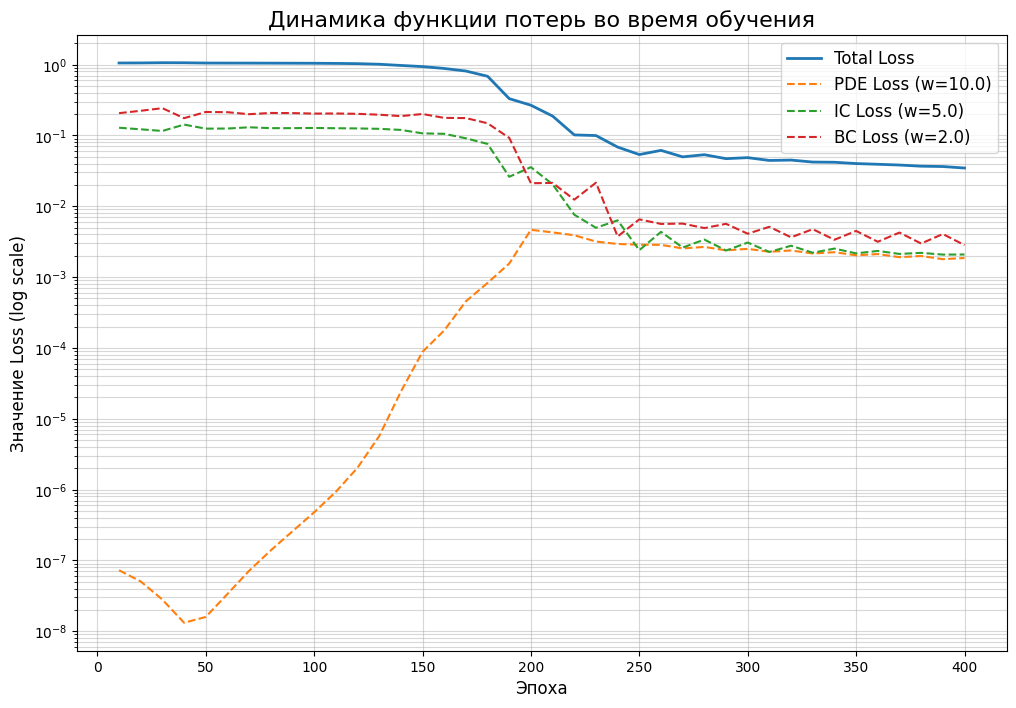

In [8]:
def plot_loss_history(epoch_hist, total_loss_hist, pde_loss_hist, ic_loss_hist, bc_loss_hist):
    plt.figure(figsize=(12, 8))
    plt.semilogy(epoch_hist, total_loss_hist, label='Total Loss', linewidth=2)
    plt.semilogy(epoch_hist, pde_loss_hist, label=f'PDE Loss (w={w_pde})', linestyle='--')
    plt.semilogy(epoch_hist, ic_loss_hist, label=f'IC Loss (w={w_ic})', linestyle='--')
    plt.semilogy(epoch_hist, bc_loss_hist, label=f'BC Loss (w={w_bc})', linestyle='--')
    plt.title('Динамика функции потерь во время обучения', fontsize=16)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel('Значение Loss (log scale)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()

plot_loss_history(epoch_history, total_loss_history, pde_loss_history, ic_loss_history, bc_loss_history)

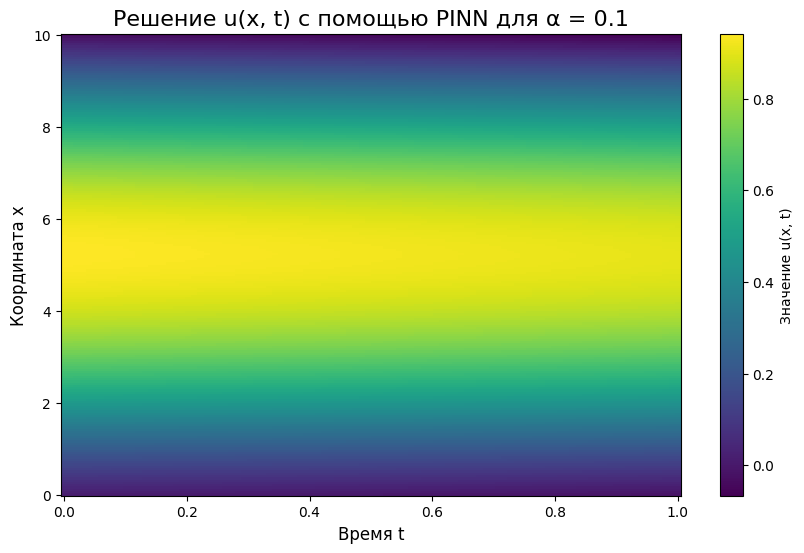

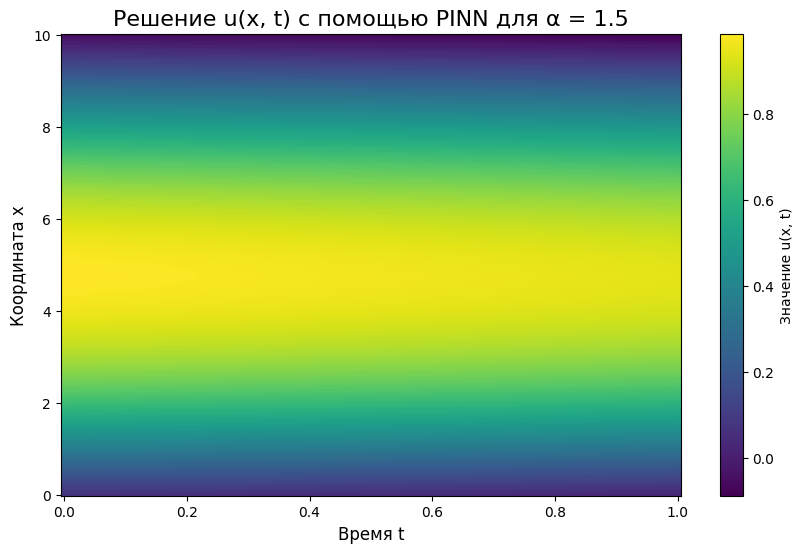

In [9]:
def plot_solution(model, L, T_MAX, device, alpha_val):
    model.eval()
    x_res, t_res = 200, 100
    x_grid = torch.linspace(0, L, x_res, device=device)
    t_grid = torch.linspace(0, T_MAX, t_res, device=device)
    X, T = torch.meshgrid(x_grid, t_grid, indexing='ij')

    # Создаем третий компонент - alpha, который теперь фиксирован для графика
    Alpha = torch.full_like(X, alpha_val)

    points_to_predict = torch.stack([X.flatten(), T.flatten(), Alpha.flatten()], dim=1)

    with torch.no_grad():
        u_pred = model(points_to_predict)
    U_pred = u_pred.view(x_res, t_res)

    X_np, T_np, U_pred_np = X.cpu().numpy(), T.cpu().numpy(), U_pred.cpu().numpy()

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(T_np, X_np, U_pred_np, shading='auto', cmap='viridis')
    plt.colorbar(label='Значение u(x, t)')
    plt.title(f'Решение u(x, t) с помощью PINN для α = {alpha_val}', fontsize=16)
    plt.xlabel('Время t', fontsize=12)
    plt.ylabel('Координата x', fontsize=12)
    plt.show()

# Визуализируем решение для двух разных alpha из обученного диапазона
plot_solution(pinn_model, L, T_MAX, device, alpha_val=ALPHA_MIN)
plot_solution(pinn_model, L, T_MAX, device, alpha_val=ALPHA_MAX)

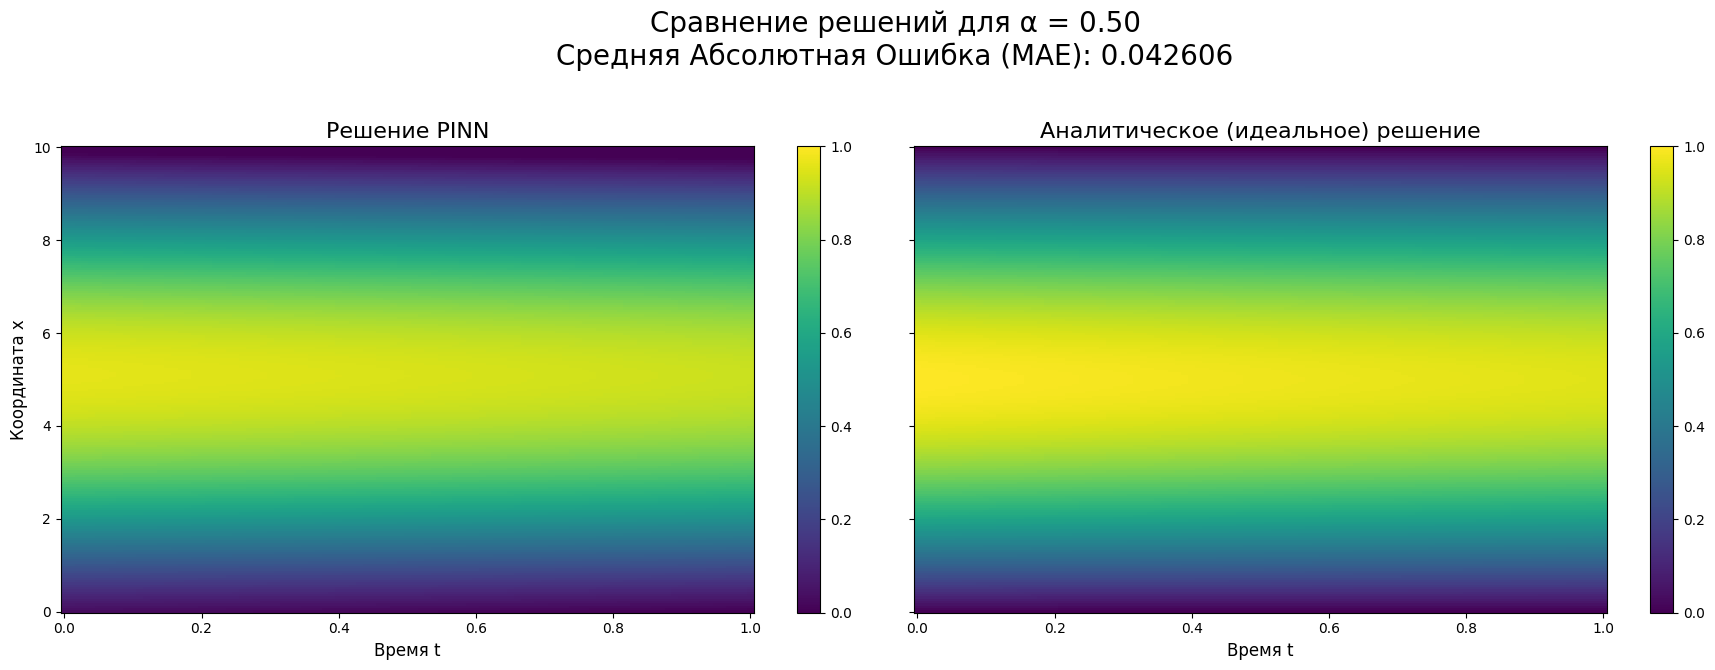

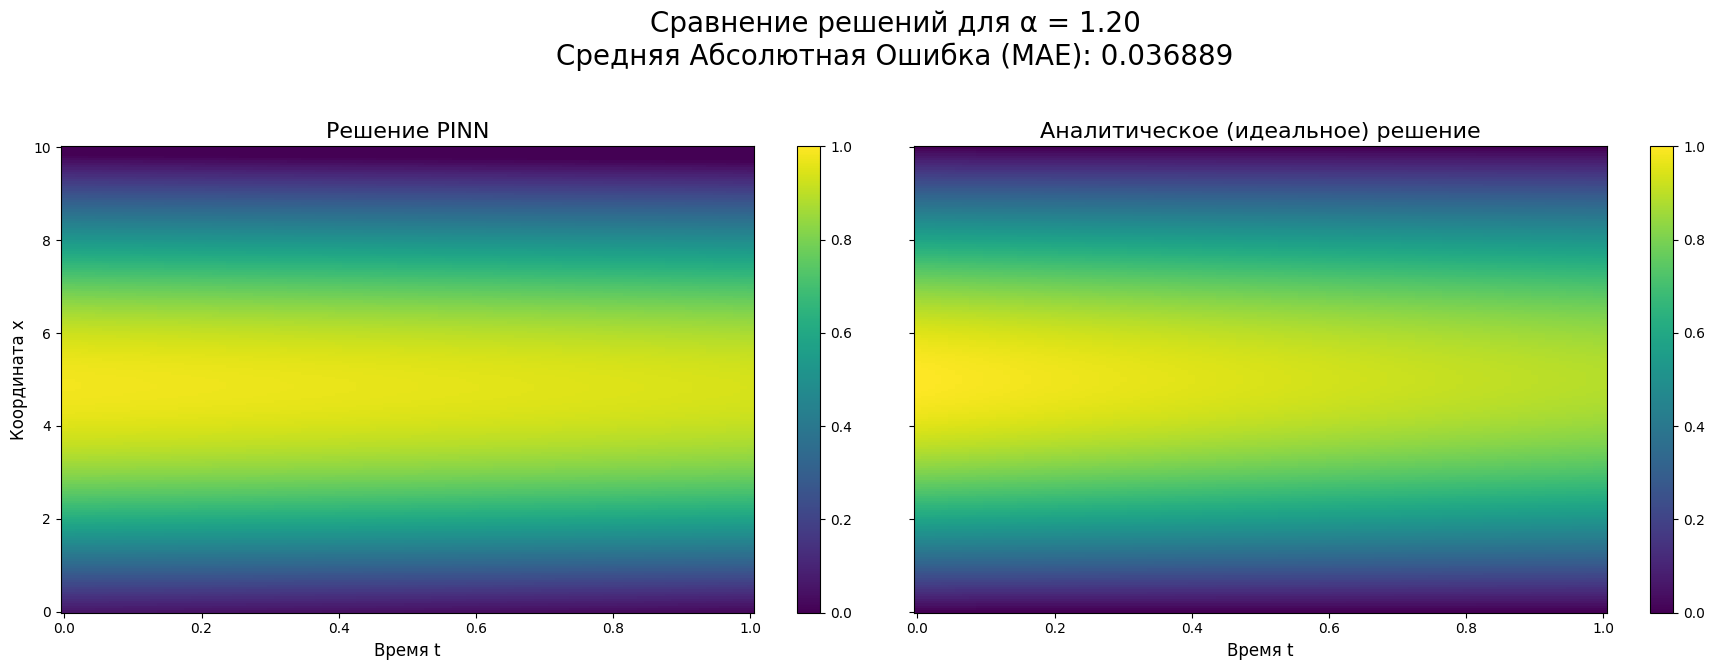

In [10]:
def plot_comparison_and_calculate_mae(model, L, T_MAX, device, alpha_val):

    model.eval()  # Переводим модель в режим оценки

    # 1. Создаем плотную сетку точек для качественной визуализации
    x_res, t_res = 200, 101
    x_grid = torch.linspace(0, L, x_res, device=device)
    t_grid = torch.linspace(0, T_MAX, t_res, device=device)
    X, T = torch.meshgrid(x_grid, t_grid, indexing='ij')

    # 2. Получаем предсказание от PINN
    # Создаем третий компонент - alpha, который фиксирован для этого графика
    Alpha = torch.full_like(X, alpha_val)
    points_to_predict = torch.stack([X.flatten(), T.flatten(), Alpha.flatten()], dim=1)

    with torch.no_grad():
        u_pred_flat = model(points_to_predict)
    U_pred = u_pred_flat.view(x_res, t_res)

    # 3. Вычисляем точное аналитическое решение на той же сетке
    U_analytical = analytical_solution_heat(X, T, Alpha, L)

    # 4. Вычисляем Среднюю Абсолютную Ошибку (Mean Absolute Error)
    mae = torch.mean(torch.abs(U_pred - U_analytical)).item()

    # 5. Готовим данные для построения графиков (переносим на CPU)
    X_np = X.cpu().numpy()
    T_np = T.cpu().numpy()
    U_pred_np = U_pred.cpu().numpy()
    U_analytical_np = U_analytical.cpu().numpy()

    # 6. Строим графики
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

    # График решения PINN
    im1 = axes[0].pcolormesh(T_np, X_np, U_pred_np, shading='auto', cmap='viridis', vmin=0, vmax=1)
    axes[0].set_title('Решение PINN', fontsize=16)
    axes[0].set_xlabel('Время t', fontsize=12)
    axes[0].set_ylabel('Координата x', fontsize=12)
    fig.colorbar(im1, ax=axes[0])

    # График аналитического решения
    im2 = axes[1].pcolormesh(T_np, X_np, U_analytical_np, shading='auto', cmap='viridis', vmin=0, vmax=1)
    axes[1].set_title('Аналитическое (идеальное) решение', fontsize=16)
    axes[1].set_xlabel('Время t', fontsize=12)
    fig.colorbar(im2, ax=axes[1])

    # Добавляем общий заголовок с информацией об ошибке
    fig.suptitle(f'Сравнение решений для α = {alpha_val:.2f}\n'
                 f'Средняя Абсолютная Ошибка (MAE): {mae:.6f}',
                 fontsize=20)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Корректируем расположение, чтобы заголовок не наезжал
    plt.show()

plot_comparison_and_calculate_mae(pinn_model, L, T_MAX, device, alpha_val=0.5)

    # Вызываем еще раз для другого alpha, чтобы проверить универсальность модели
plot_comparison_and_calculate_mae(pinn_model, L, T_MAX, device, alpha_val=1.2)